In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from data_preprocessing.DataLoader import DataLoader
from sklearn.preprocessing import StandardScaler

In [3]:
def unite_sets(deliveries, products, sessions, users):
    deliveries["deltas"] = deliveries["delivery_timestamp"] - deliveries["purchase_timestamp"]

    # divide category
    categories = products.category_path.str.split(';', expand=True)
    products = pd.concat([products, categories], axis=1)
    products = products.drop(columns=['category_path'])
    products = products.rename(
        columns={0: "primary_category", 1: "secondary_category", 2: "tertiary_category", 3: "quaternary_category"})


    deliveries_sessions = pd.merge(deliveries, sessions, left_on="purchase_id", right_on="purchase_id")
    deliveries_sessions_users = pd.merge(deliveries_sessions, users, left_on="user_id", right_on="user_id")
    deliveries_sessions_users_products = pd.merge(deliveries_sessions_users, products, left_on="product_id", right_on="product_id")

    deliveries_sessions_users_products.to_csv('../out.csv')
    return deliveries_sessions_users_products

In [4]:
#Function for labeling rows
def labelTimeOfDay(row):
    hour = row['purchase_timestamp'].hour
    if(hour >= 6 and hour < 12):
        return "Morning"
    elif(hour >= 12 and hour < 18):
        return "Afternoon"
    elif(hour >=18 and hour < 24):
        return "Evening"
    else:
        return "Night"

In [5]:
def one_hot_encode(united, s):
    y = pd.get_dummies(united[s], prefix=s)
    united = united.join(other=y)
    united = united.loc[:, united.columns != s]
    return united

In [6]:
    def oneHotEncode(united, columns):
        for column in columns:
            united = one_hot_encode(united, column)
        return united

In [8]:
d = DataLoader.load_data_from_path("data")

products = d.products
deliveries = d.deliveries
sessions = d.sessions
users = d.users

united = unite_sets(deliveries, products, sessions, users)

# nie wnosi zadnej informacji wiec wyrzucamy daną kolumnę
united = united.loc[:, united.columns != 'event_type']
united = united.loc[:, united.columns != 'name']
united = united.loc[:, united.columns != 'street']
united = united.loc[:, united.columns != 'product_name']
united = united.loc[:, united.columns != 'delivery_timestamp']
united = united.loc[:, united.columns != 'timestamp']
united = united.loc[:, united.columns != 'purchase_id']
united = united.loc[:, united.columns != 'product_id']
united = united.loc[:, united.columns != 'user_id']
united = united.loc[:, united.columns != 'session_id']
united = united.loc[:, united.columns != 'primary_category']
united = united.loc[:, united.columns != 'secondary_category']
united = united.loc[:, united.columns != 'tertiary_category']
united = united.loc[:, united.columns != 'quaternary_category']
united = united.loc[:, united.columns != 'offered_discount']
united = united.loc[:, united.columns != 'price']

united.to_csv("test.csv")

united.loc[:,'time_of_day'] = united.apply(lambda row: labelTimeOfDay(row), axis=1)
united['weekday'] = united['purchase_timestamp'].dt.day_name()
united = united.loc[:, united.columns != 'purchase_timestamp']

united = oneHotEncode(united, {'city', 'delivery_company', 'time_of_day', 'weekday'})
# united = one_hot_encode(united, 'city')
# united.to_csv("city.csv")
# united = one_hot_encode(united, 'delivery_company')
# united = one_hot_encode(united, 'time_of_day')
# united = one_hot_encode(united, 'weekday')


united['deltas'] = pd.to_numeric(united['deltas'].dt.days, downcast='integer')


# normalizacja deltas
# unitated['deltas'] = unitated['deltas'] /unitated['deltas'].abs().max()


# train, test = train_test_split(unitated, test_size=0.2)
# X_train = train.loc[:, train.columns != 'deltas']
# y_train = train['deltas']

# X_test = test.loc[:, test.columns != 'deltas']
# y_test = test['deltas']

In [9]:
x = united.drop('deltas', axis=1)
y = united['deltas']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# #Scaling
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
X_test.to_csv("notzero.csv")

In [10]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [11]:
y_pred = model.predict(X_test)

In [12]:
y_test

7168    1
3910    0
4975    3
5849    2
4775    1
       ..
3971    2
2758    2
4966    2
5078    2
4253    2
Name: deltas, Length: 1499, dtype: int8

In [13]:
y_pred

array([0, 0, 3, ..., 0, 0, 0], dtype=int8)

In [14]:
accuracy = accuracy_score(y_test, y_pred)*100

In [15]:
accuracy

25.617078052034692

In [19]:
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

In [20]:
from sklearn.metrics import classification_report,confusion_matrix

#Evaluate predictions for train data
print(confusion_matrix(y_train,predict_train))
print(classification_report(y_train,predict_train))

[[ 912    0    0    0    0]
 [2202  316    0   66  211]
 [ 681  226    0  275  521]
 [  66   15    0  185  267]
 [   0    0    0    0   51]]
              precision    recall  f1-score   support

           0       0.24      1.00      0.38       912
           1       0.57      0.11      0.19      2795
           2       0.00      0.00      0.00      1703
           3       0.35      0.35      0.35       533
           4       0.05      1.00      0.09        51

    accuracy                           0.24      5994
   macro avg       0.24      0.49      0.20      5994
weighted avg       0.33      0.24      0.18      5994



/home/zuznanna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zuznanna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zuznanna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
#Evaluate predictions for test data
print(confusion_matrix(y_test,predict_test))
print(classification_report(y_test,predict_test))

[[236   1   0   1   0]
 [549  86   0  14  36]
 [168  42   0  76 145]
 [ 16   1   0  44  65]
 [  0   0   0   1  18]]
              precision    recall  f1-score   support

           0       0.24      0.99      0.39       238
           1       0.66      0.13      0.21       685
           2       0.00      0.00      0.00       431
           3       0.32      0.35      0.34       126
           4       0.07      0.95      0.13        19

    accuracy                           0.26      1499
   macro avg       0.26      0.48      0.21      1499
weighted avg       0.37      0.26      0.19      1499



/home/zuznanna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zuznanna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zuznanna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<function matplotlib.pyplot.show(close=None, block=None)>

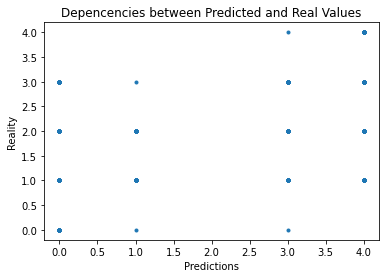

In [16]:
plt.plot(y_pred, y_test,".")
plt.title("Depencencies between Predicted and Real Values")
plt.xlabel("Predictions")
plt.ylabel("Reality")
plt.show

In [17]:
X_test.to_csv("test.csv")

In [18]:
import pickle
f = open('models/bayes_1.0.0.pickle', 'wb')
pickle.dump(model, f)
f.close()